In [10]:
# Linear Regression With Stochastic Gradient Descent for Wine Quality
from random import seed
from random import randrange
from csv import reader
from math import sqrt

In [115]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset
    
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# calculate column means
def column_means(dataset):
    means = [0 for i in range(len(dataset[0]))]
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        means[i] = sum(col_values) / float(len(dataset))
    return means
# calculate column standard deviations
def column_stdevs(dataset, means):
    stdevs = [0 for i in range(len(dataset[0]))]
    for i in range(len(dataset[0])):
        variance = [pow(row[i]-means[i], 2) for row in dataset]
        stdevs[i] = sum(variance)
    stdevs = [sqrt(x/(float(len(dataset)-1))) for x in stdevs]
    return stdevs  

# standardize dataset
def standardize_dataset(dataset, means, stdevs):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - means[i]) / stdevs[i]            

In [28]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate root mean squared error
def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(actual))
    return sqrt(mean_error)

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        rmse = rmse_metric(actual, predicted)
        scores.append(rmse)
    return scores    

In [174]:
# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return yhat
    
# Estimate linear regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train[0]))]
    for _ in range(n_epoch):
        for row in train:
            yhat = predict(row, coef)
            error = yhat - row[-1]
            coef[0] = coef[0] - l_rate * error
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] - l_rate * error * row[i]
            # print(l_rate, n_epoch, error)
    return coef

# Estimate linear regression coefficients using Batch gradient descent
def coefficients_bgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train[0]))]
    for _ in range(n_epoch):
        m = len(train)
        predictions = [predict(row, coef) for row in train]
        actual = [row[-1] for row in train]
        error = [predictions[i]- actual[i] for i in range(len(train))]
        gradient = []
        for i in range(len(train[0])):
            grad = 0
            for j in range(m):
                grad += error[j]*train[j][i]
            grad = grad/m     
            gradient.append(grad)
        coef[0] = coef[0] - l_rate * sum(error)/m    
        for i in range(len(coef)-1):
                coef[i + 1] = coef[i + 1] - l_rate * gradient[i]
    return coef

# Linear Regression Algorithm With Stochastic Gradient Descent
def linear_regression_sgd(train, test, l_rate, n_epoch):
    predictions = list()
    coef = coefficients_bgd(train, l_rate, n_epoch) # sgd or bgd
    for row in test:
        yhat = predict(row, coef)
        predictions.append(yhat)
    return(predictions)

In [175]:
# Linear Regression on wine quality dataset
seed(1)
# load and prepare data
# Load dataset
filepath = '/Users/maheshwars/Desktop/venv/data'
filename = filepath +'/winequality-white.csv'
dataset = load_csv(filename)
print('Loaded data file {0} with {1} rows and {2} columns'.format(filename, len(dataset),
len(dataset[0])))

dataset=dataset[1:] #removing headers

Loaded data file /Users/maheshwars/Desktop/venv/data/winequality-white.csv with 4899 rows and 12 columns


In [176]:
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
    
# normalize
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# evaluate algorithm
n_folds = 6
l_rate = 0.01
n_epoch = 80
scores = evaluate_algorithm(dataset, linear_regression_sgd, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Mean RMSE: %.3f' % (sum(scores)/float(len(scores))))

Scores: [0.1883742020354242, 0.18156506980082335, 0.18584140065652377, 0.18147042425490809, 0.18358054851923714, 0.1825127519451661]
Mean RMSE: 0.184


In [129]:
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)

# standardize
# Estimate mean and standard deviation
means = column_means(dataset)
stdevs = column_stdevs(dataset, means)

print(means[0])
print(stdevs[0])
print(dataset[0])
# standardize dataset
standardize_dataset(dataset, means, stdevs)
print(dataset[0])

# evaluate algorithm
n_folds = 6
l_rate = 0.001
n_epoch = 50
scores = evaluate_algorithm(dataset, linear_regression_sgd, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Mean RMSE: %.3f' % (sum(scores)/float(len(scores))))

6.854787668436097
0.843868227687513
[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1.001, 3.0, 0.45, 8.8, 6.0]
[0.17207939201815275, -0.08176155310773502, 0.21325842850702686, 2.8210611444304767, -0.03535139104863334, 0.5698733938600623, 0.7444890236943132, 2.3312739959640187, -1.2467939857497483, -0.34914860989227153, -1.393010236208451, 0.13785606532441785]
Scores: [0.8389484734352578, 0.875894286869886, 0.8582381986589324, 0.8734140665307771, 0.8435195451239607, 0.8359128794903186]
Mean RMSE: 0.854


### For some reasons standardization did not result in better performance
#### From below plots we could see that the input data distribution is not gaussion and hence standardization did not help

In [138]:
#pip install matplotlib

Loaded data file /Users/maheshwars/Desktop/venv/data/winequality-white.csv with 4899 rows and 12 columns


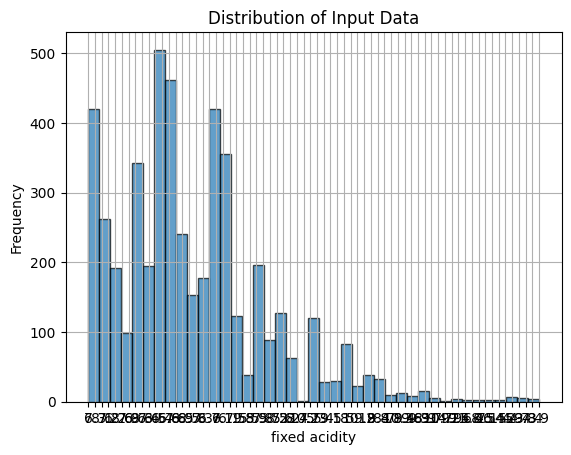

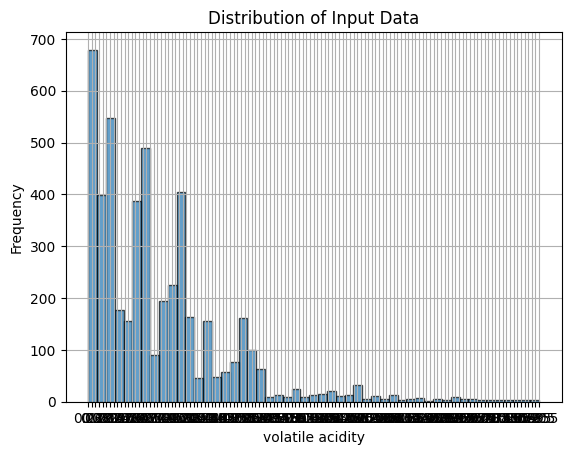

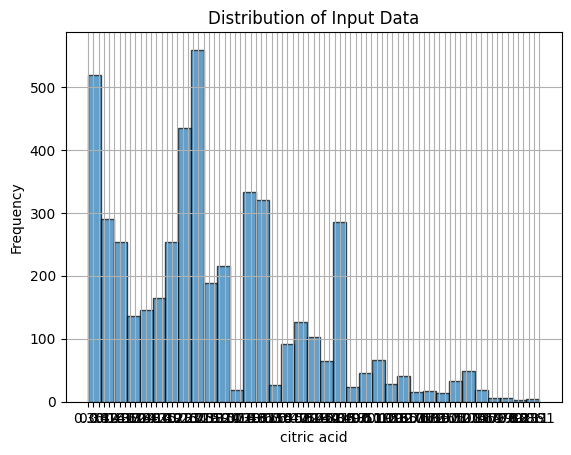

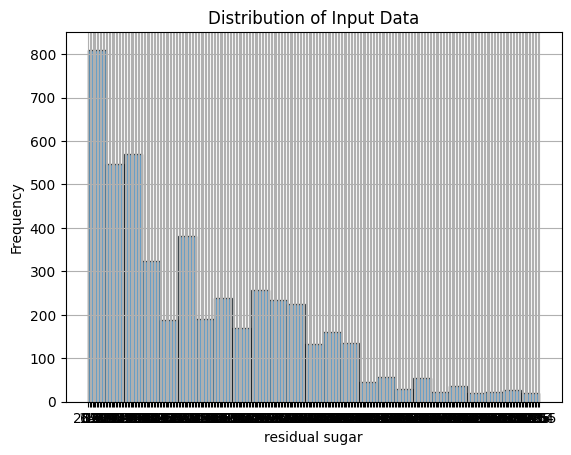

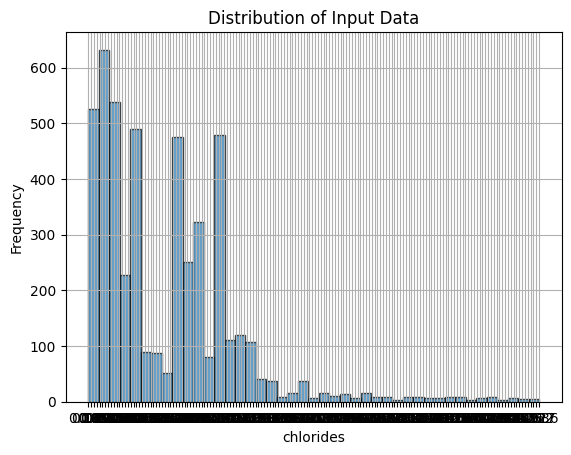

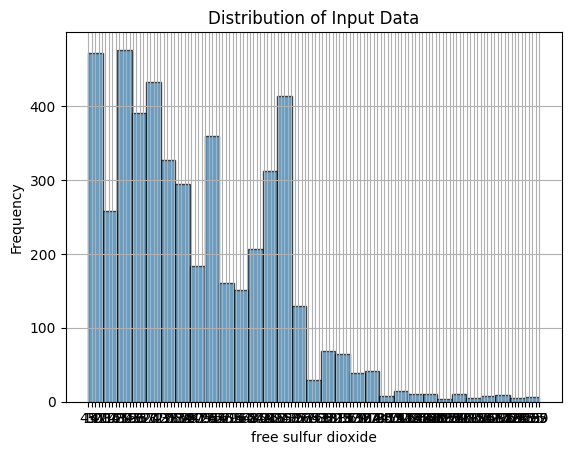

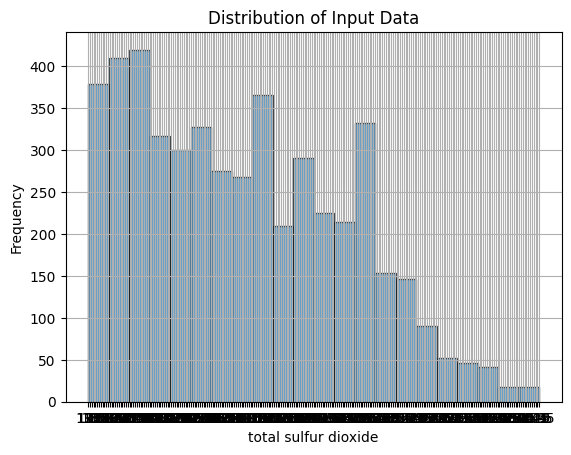

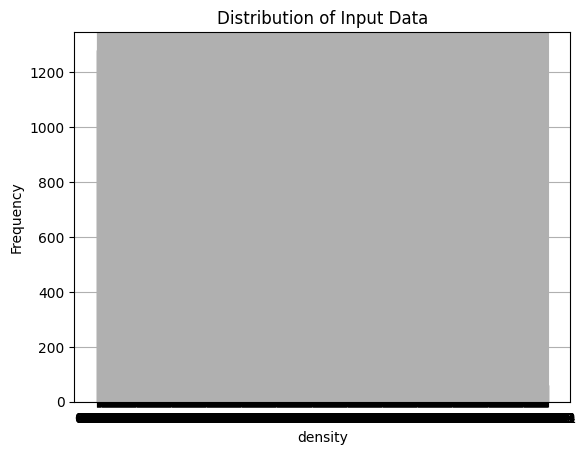

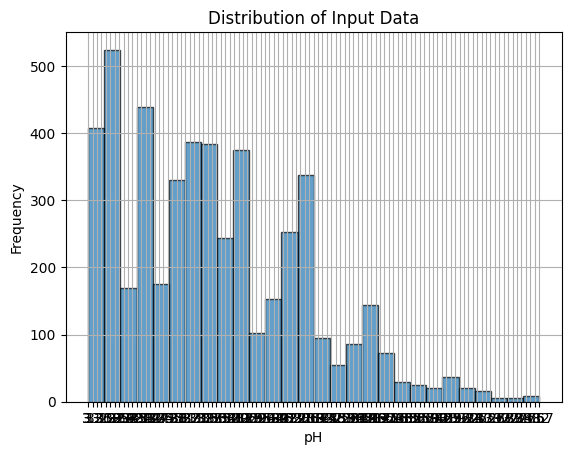

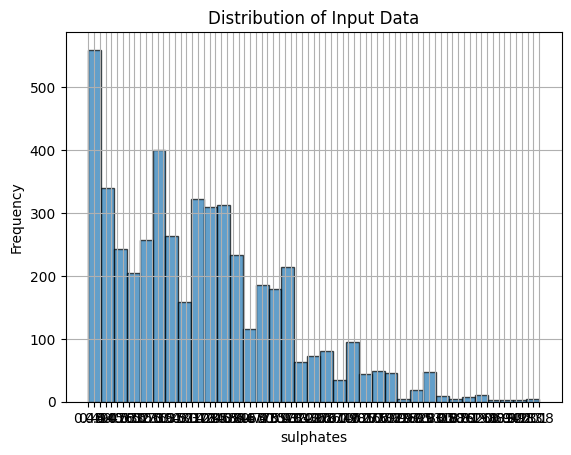

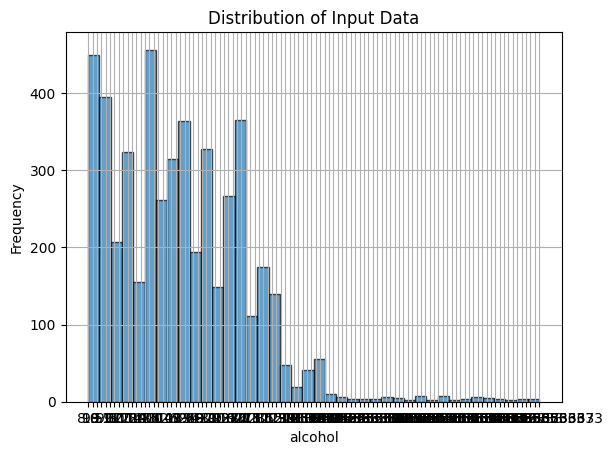

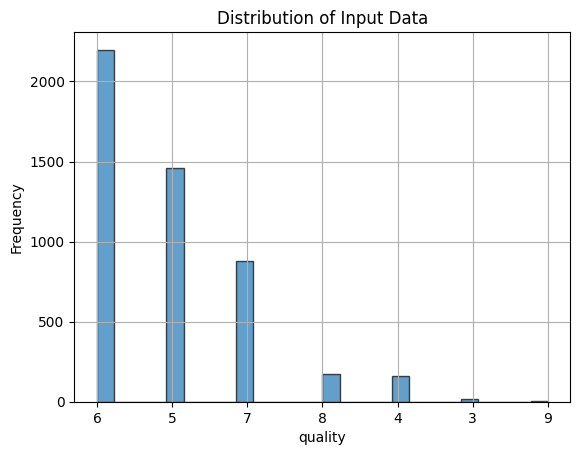

In [143]:
import matplotlib.pyplot as plt
# load and prepare data
# Load dataset
filepath = '/Users/maheshwars/Desktop/venv/data'
filename = filepath +'/winequality-white.csv'
dataset = load_csv(filename)
print('Loaded data file {0} with {1} rows and {2} columns'.format(filename, len(dataset),
len(dataset[0])))
data_with_headers = dataset
dataset=dataset[1:] #removing headers

# Example input list

for i in range(len(dataset[0])):
    data = [row[i] for row in dataset]
    # Plot histogram (distribution)
    plt.hist(data, bins='auto', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Input Data')
    plt.xlabel(data_with_headers[0][i])
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Logistic Regression

In [178]:
# Logistic Regression on Diabetes Dataset
from random import seed
from random import randrange
from csv import reader
from math import exp

# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())
        
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
    
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
    
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
    
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Make a prediction with coefficients
def predict(row, coefficients):
    yhat = coefficients[0]
    for i in range(len(row)-1):
        yhat += coefficients[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train[0]))]
    for _ in range(n_epoch):
        for row in train:
            yhat = predict(row, coef)
            error = row[-1] - yhat
            coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)  # loss_gradient when MSE is loss function not cross entropy
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef

# Logistic Regression Algorithm With Stochastic Gradient Descent
def logistic_regression(train, test, l_rate, n_epoch):
    predictions = list()
    coef = coefficients_sgd(train, l_rate, n_epoch)
    for row in test:
        yhat = predict(row, coef)
        yhat = round(yhat)
        predictions.append(yhat)
    return(predictions)

In [180]:
# Test the logistic regression algorithm on the diabetes dataset
seed(1)
# load and prepare data
filepath = '/Users/maheshwars/Desktop/venv/data'
filename = filepath +'/diabetes.csv'
dataset = load_csv(filename)
print('Loaded data file {0} with {1} rows and {2} columns'.format(filename, len(dataset),
len(dataset[0])))

dataset = dataset[1:]
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
    
# normalize
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# evaluate algorithm
n_folds = 5
l_rate = 0.1
n_epoch = 100
scores = evaluate_algorithm(dataset, logistic_regression, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Loaded data file /Users/maheshwars/Desktop/venv/data/diabetes.csv with 769 rows and 9 columns
Scores: [73.8562091503268, 78.43137254901961, 81.69934640522875, 75.81699346405229, 75.81699346405229]
Mean Accuracy: 77.124%
